In [28]:
from fastbook import *
import matplotlib.pyplot as plt
from datetime import datetime

In [22]:
def delete_images(extensions, depth):
    for ext in extensions:
        command = f'find . -maxdepth {depth} -type f -name "{ext}" -delete'
        os.system(command)

def download_single_image(term, attempts=10, view=True):
    dest = f'{term}.jpg'
    urls = search_images_ddg(term, max_images=10)
    for i in range(attempts):
        try:
            download_url(urls[i], dest, show_progress=False)
            image = Image.open(dest)
            if view:
                display(image.to_thumb(256, 256))
            break
        except Exception as e:
            print(f'Error on attempt {i+1}: {e}')
    
    return dest

def download_dataset(terms, subfolder, n_images=200, force=False):
    path = Path(os.path.join('datasets', subfolder))

    if path.exists() and not force:
        return path
    
    for term in terms:
        t0 = datetime.now()
        dest = path/term
        dest.mkdir(exist_ok=True, parents=True)
        urls = search_images_ddg(term, max_images=n_images)
        download_images(dest, urls=urls[:])
        resize_images(dest, max_size=400, dest=dest)
        t1 = datetime.now()
        print(f'{term} images downloaded in {(t1 - t0).total_seconds():.2f} s')
    
    failed = verify_images(get_image_files(path))
    failed.map(Path.unlink)

    return path


In [ ]:
extensions = ['*.jpg', '*.JPG', '*.jpeg', '*.png', '*.webp', '*.jpg!d', '*.ashx', '*.gif']
delete_images(extensions, depth=1)

Error on attempt 1: cannot identify image file '/Users/jamesbyers/Documents/Code/github/learn-in-public/cat.jpg'


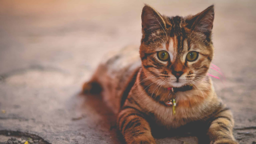

In [21]:
dest = download_single_image('cat')

In [10]:
terms = [
    'sushi',
    'udon',
    'tofu',
    'tempura',
    'yakitori',
    'sashini',
    'ramen',
    'donburi',
    'natto',
    'oden',
    'tamagoyaki',
    'soba',
    'tonkatsu',
    'kashi pan',
    'sykiyaki',
    'miso soup',
    'okonomiyaki',
    'mentaiko',
    'nikujaga',
    'curry rice',
    'unagi no kabayaki',
    'shabu shabu hot pot',
    'onigiti',
    'gyoza',
    'takoyaki',
    'kaiseki ryori',
    'edamame',
    'yakisoba',
    'chawanmushi',
    'wagashi']

# terms = ['sushi']
path = download_dataset(terms, 'japanese_food', force=False)

In [13]:
blocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    get_items=get_image_files,
    item_tfms=[Resize(192, method='squish')])

dls = blocks.dataloaders(path)

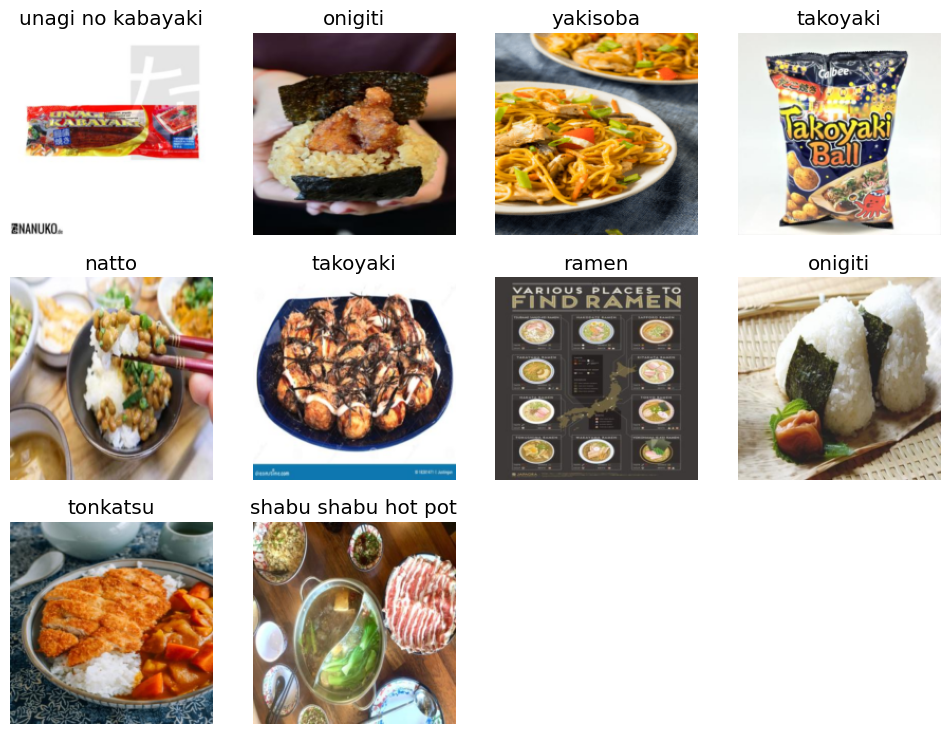

In [14]:
dls.show_batch(max_n=10)

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.606538,1.310496,0.348524,00:32


epoch,train_loss,valid_loss,error_rate,time
0,1.242640,0.892150,0.251605,00:40
1,0.674059,0.741645,0.204750,00:39
2,0.304306,0.725248,0.198973,00:40


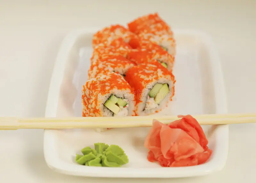

Category: sushi; Prob: 89.85%
<class 'torch.Tensor'>


In [31]:
term = 'tasty sushi'
def inference_new_image(term, display_result=True):
    '''
    Download and perform inference on a new image

    Args:
        term (string): description of image to be downloaded from duckduckgo
        display_result (bool, default True): set to True to display the image

    Returns:
        cat (string): category of prediction
        cat_idx (int): index of the category in the torch tensor 'probs'
        probs (torch tensor): 1D torch tensor (of tensors) representing probabilities for each category
    '''
    image_dest = download_single_image(term, view=False)
    cat, cat_idx, probs = learn.predict(image_dest)
    
    if display_result:
        display(Image.open(image_dest).to_thumb(256, 256))
        print(f'Category: {cat}; Prob: {probs[cat_idx]*100:.2f}%')

    return cat, cat_idx, probs

cat, cat_idx, probs = inference_new_image(term, display_result=True);
print(type(probs))

In [33]:
probs[0]

tensor(2.4192e-05)

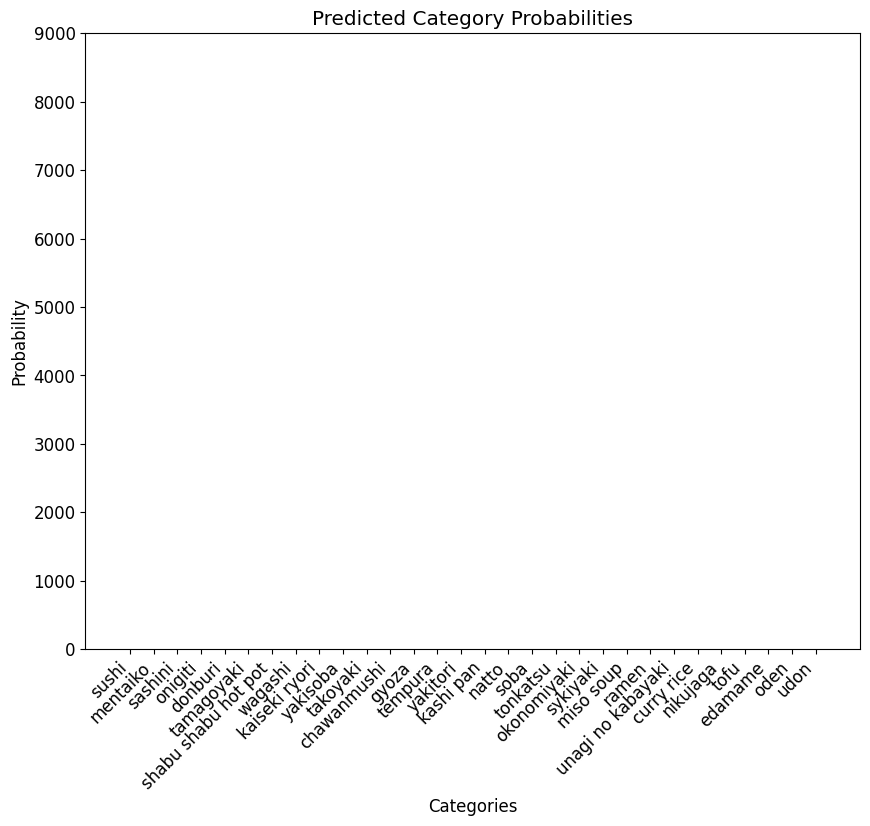

In [30]:
image_dest = download_single_image(term, view=True)
_, _, probs = learn.predict(image_dest)

def plot_cat_probabilities(probs, learn):
    categories = learn.dls.vocab

    sorted_indices = sorted(range(len(probs)), key=lambda x: probs[x], reverse=True)
    sorted_categories = [categories[idx] for idx in sorted_indices]
    sorted_probs = [probs[idx].item() for idx in sorted_indices]

    # Create the bar graph
    plt.figure(figsize=(10, 8))  # Set the figure size
    plt.bar(sorted_categories, sorted_probs, color='skyblue')  # Create a bar chart
    plt.xlabel('Categories')  # Label on X axis
    plt.ylabel('Probability')  # Label on Y axis
    plt.title('Predicted Category Probabilities')

    plt.xticks(rotation=45, ha="right")
    plt.yticks([x*100 for x in range(0, int(max(sorted_probs)*100)+10, 10)])
    plt.show() 
plot_cat_probabilities(probs, learn)

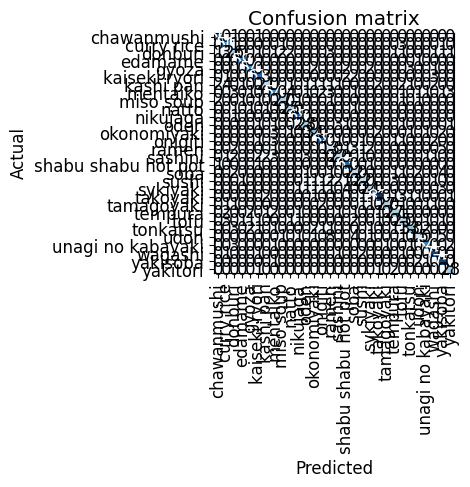

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()